# Classification

Continuation of Segmentaion process in which musical primitives found via Template Matching.

In [12]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Image loading, binarization, inversion and display
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
def image_bin_otsu(image_gs):
    ret,image_bin = cv2.threshold(image_gs, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return image_bin
def invert(image):
    return 255-image
def display_image(image, color= False):
    plt.figure()
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')
    plt.show()
    
# Image morphological operations
def dilate(image, rows = 1, cols = 100):
    rows = int(rows)
    cols = int(cols)
    kernel = np.ones((rows,cols))
    return cv2.dilate(image, kernel, iterations=1)
def erode(image, rows = 1, cols = 100):
    rows = int(rows)
    cols = int(cols)
    kernel = np.ones((rows, cols))
    return cv2.erode(image, kernel, iterations=1)
def open_image(image, rows = 1, cols = 100):
    rows = int(rows)
    cols = int(cols)
    return dilate(erode(image, rows, cols), rows, cols)

# Horizontal projection
def horizontal_projection(image):
    hor_proj = []
    for i in range(len(image)):
        row_sum = 0
        for j in range(len(image[i])):
            row_sum += image[i][j] == 255
        hor_proj.append([255] * row_sum + [0] * (len(image[0]) - row_sum))

    return hor_proj

# Image crop
def crop_image(image, crop_start = None, crop_width = None):
    if crop_width is None:
        crop_width = len(image[0]) // 10
        
    if crop_start is None:
        end = 0
        for row in image:
            s = sum(row) / 255
            if s > end:
                end = s

        crop_start = end - crop_width
        
    cutoff = image[:]
    
    for i in range(len(cutoff)):
        cutoff[i] = cutoff[i][crop_start : crop_start + crop_width] 

    cutoff = np.array(cutoff, dtype = np.uint8)
    return cutoff

# Find Y coordinates of white pixels
def find_y(image):
    y = []
    for i in range(len(image)):
        for j in range(len(image[i])):
            if (image[i][j] == 255) and (i not in y):
                y.append(i)
    return sorted(y)

# Intersect two lists
def intersect_lists(first, second):
    ret_val = []
    for val in first:
        if val in second:
            ret_val += [val]
    return ret_val

# Group points and get distances
def label_y(y_list):
    labels = [[]]
    line_distances = []
    prev_y = None
    for y in y_list:
        if prev_y is not None:
            if y - prev_y > 1:
                labels.append([])
                line_distances += [y - prev_y]
        labels[-1] += [y]
        prev_y = y
    return labels, line_distances

# Find lines
def find_lines(image):
    first = find_y(crop_image(horizontal_projection(image)))
    second = find_y(open_image(image))
    return label_y(intersect_lists(first, second))

# Remove lines
def remove_lines(org_image, tolerance = 0, lines = None, topBotPixelRemoval = False, widthBasedRemoval = True):
    image = org_image.copy()
    
    if lines == None:
        lines, distances = find_lines(org_image)
    
    if topBotPixelRemoval:
        for line in lines:
            top = line[0]
            bot = line[-1]
            for j in range(len(image[top])):
                remove = True
                is_line = False
                for row in image[top:bot+1]:
                    if row[j] == 255:
                        is_line = True
                        break
                if not is_line:
                    continue
                # check 2 pixels above and below
                diff = 2
                for row in image[top - diff : top]:
                    if row[j] == 255:
                        remove = False
                        break
                if remove:
                    for row in image[bot + 1: bot + diff + 1]:
                        if row[j] == 255:
                            remove = False
                            break
                if remove:
                    for row in image[top:bot+1]:
                        row[j] = 0
    
    if widthBasedRemoval:
        avg_thickness = lines[:]
        for i, line in enumerate(avg_thickness):
            avg_thickness[i] = len(line)
        avg_thickness = sum(avg_thickness) * 1./len(avg_thickness)

        for j in range(len(image[0])):
            white = False
            for i in range(len(image)):
                if image[i][j] == 255:
                    if not white:
                        start = i
                    white = True
                else:
                    if white:
                        thickness = i - start
                        if thickness <= (avg_thickness + tolerance):
                            for row in image[start : i]:
                                row[j] = 0
                    white = False
    return image

# Vertical lines recognition
def get_region(image, row, col):
    coords = [(row, col)]
    idx = 0
    while (idx < len(coords)):
        row, col = coords[idx]
        for dr in [-1, 0, 1]:
            for dc in [-1, 0, 1]:
                r = row + dr
                c = col + dc
                if r >= 0 and c >= 0 and r < len(image) and c < len(image[r]):
                    if image[r][c] == 255 and ((r,c) not in coords):
                        coords += [(r,c)]
        idx += 1
    return coords

def find_vertical_lines(image):
    # Find lines, distances
    lines, distances = find_lines(image)
    
    # Calculate staff spacing
    distances = [distances[i] for i in range(len(distances)) if (i+1) % 5 != 0 ]
    avg_spacing = sum(distances) * 1./len(distances)

    # Find vertical objects
    img_open = open_image(remove_lines(image), 1.5 * avg_spacing, 1)
    
    # Label regions of interest
    regions = []
    for row in range(len(img_open)):
        for col in range(len(img_open[row])):
            if img_open[row][col] == 0:
                continue
            isFound = False
            for region in regions:
                if (row,col) in region:
                    isFound = True
            if isFound:
                continue
            regions.append(get_region(img_open, row, col))

    return img_open, regions


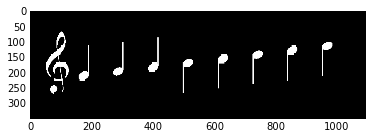

In [2]:
org_image = load_image("test_images/staff-with-notes.jpg")
img_gray = image_gray(org_image)
img_otsu = image_bin_otsu(img_gray)
inv_img = invert(img_otsu)
img_wo_lines = remove_lines(inv_img, 0)
display_image(img_wo_lines)

[25, 24, 24, 25, 65, 25, 24, 24, 25, 65, 25, 24, 24, 25]
[25, 24, 24, 25, 25, 24, 24, 25, 25, 24, 24, 25]
